In [1]:
from shapely.geometry import Polygon
from sqlite3 import connect
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

conn = connect('../data/charts_coarse.db')
df = pd.read_sql('select * from pages', conn)
xdf = df.dropna(subset=['annotations', 'prediction'])
xdf = xdf[['annotations', 'prediction']]

In [121]:
def get_coords(row):
    x, y, h, w = row.x, row.y, row.height, row.width
    return (x, y), (x + w, y), (x + w, y + h), (x, y + h)

def get_dfs(row):
    annotation, prediction = map(json.loads, row.tolist())
    y_true = [v['value'] for v in annotation]
    y_true = pd.DataFrame.from_records([
        {k: v[k] for k in ['x', 'y', 'height', 'width', 'rectanglelabels']} for v in y_true
    ])
    y_pred = [v['value'] for v in prediction]
    y_pred = pd.DataFrame.from_records([
        {k: v[k] for k in ['x', 'y', 'height', 'width', 'rectanglelabels']} for v in y_pred
    ])
    y_true['label'] = y_true.pop('rectanglelabels').apply(lambda x: x[0])
    y_pred['label'] = y_pred.pop('rectanglelabels').apply(lambda x: x[0])
    return y_true, y_pred

def get_iou_matrix(row):
    y_true, y_pred = get_dfs(row)
    ious = {}
    for label in ['map', 'donut', 'line', 'scatter']:
        ltrue, lpred = y_true[y_true['label'] == label], y_pred[y_pred['label'] == label]
        if not any([len(ltrue), len(lpred)]):
            # If the label is absent in both annotation and prediction, continue to the next label
            continue
        
        elif len(ltrue) and not len(lpred):
            # Prediction is absent, annotation is present
            # Prediction is then a polygon with zero area
            pred_polygons = [Polygon([(0, 0), (0, 0), (0, 0), (0, 0)])]
            true_polygons = ltrue.apply(lambda row: Polygon(get_coords(row)), axis=1)
        elif len(lpred) and not len(ltrue):
            # Prediction present, annotation absent
            # Annotation is a polygon with zero area
            true_polygons = [Polygon([(0, 0), (0, 0), (0, 0), (0, 0)])]
            pred_polygons = lpred.apply(lambda row: Polygon(get_coords(row)), axis=1)
        else:
            true_polygons = ltrue.apply(lambda row: Polygon(get_coords(row)), axis=1)
            pred_polygons = lpred.apply(lambda row: Polygon(get_coords(row)), axis=1)
        iou = np.zeros(list(map(len, (pred_polygons, true_polygons))))
        for i, p_poly in enumerate(pred_polygons):
            for j, t_poly in enumerate(true_polygons):
                iou[i, j] = p_poly.intersection(t_poly).area / p_poly.union(t_poly).area
        ious[label] = iou
        
    return ious


def map_iou(row):
    mats = get_iou_matrix(row)
    thresh = np.arange(0.5, 1, 0.05)
    ious = {}
    for label, iou in mats.items():
        T = np.tile(thresh, iou.shape + (1,))
        X = np.repeat(iou[:, :, np.newaxis], 10, axis=2)
        threshed = X > T
        tp = threshed.any(axis=1).sum(axis=0)
        fp = (threshed.sum(axis=1) == 0).sum(axis=0)
        fn = (threshed.sum(axis=0) == 0).sum(axis=0)
        ious[label] = np.mean(tp / (tp + fp + fn))
    return ious

ious = map_iou(xdf.iloc[0])

In [127]:
xdf.drop([127], axis=0, inplace=True)

In [131]:
label_ious = {}
for iou in xdf.apply(map_iou, axis=1).tolist():
    for k, v in iou.items():
        if k in label_ious:
            label_ious[k].append(v)
        else:
            label_ious[k] = [v]

In [136]:
label_ious = {k: np.mean(v) for k, v in label_ious.items()}

<AxesSubplot:>

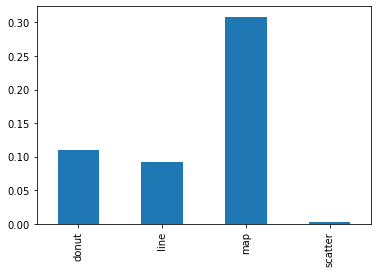

In [138]:
pd.Series(label_ious).plot(kind='bar')